In [2]:
import requests
import os
import pandas as pd
import folium
import plotly.express as px
from shapely.geometry import Polygon
import geopandas as gpd
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import numpy as np
import calendar
px.set_mapbox_access_token("pk.eyJ1IjoibXJhZmlwaCIsImEiOiJjbGMzdWZ0MTIwNmt5M3B0ODNnbzF1a3d2In0.7VgLitY9OXxhPSxlxJglfQ")
print(folium.__version__)


0.14.0


In [3]:
def fast_scandir(dirname):
    subfolders= [f.path for f in os.scandir(dirname) if f.is_dir()]
    for dirname in list(subfolders):
        subfolders.extend(fast_scandir(dirname))
    return subfolders

subfolders = fast_scandir(r'./Datasets')

In [4]:
all_street_df = []
all_ss_df = []
all_outcome_df = []
for i in range(4, len(subfolders)):
    street_file_name =  [ file for file in os.listdir(subfolders[i]) if "street" in file]
    ss_file_name = [ file for file in os.listdir(subfolders[i]) if "search" in file]
    outcome_file_name = [ file for file in os.listdir(subfolders[i]) if "outcome" in file]
    if len(street_file_name) > 0:
        df = pd.read_csv(os.path.join(subfolders[i], street_file_name[0]))
        all_street_df.append(df)
    elif len(ss_file_name) > 0:
        df = pd.read_csv(os.path.join(subfolders[i], ss_file_name[0]))
        all_ss_df.append(df)
    if len(outcome_file_name) > 0:
        df = pd.read_csv(os.path.join(subfolders[i], outcome_file_name[0]))
        all_outcome_df.append(df)

In [5]:
df = pd.concat(all_street_df, ignore_index=True)
df = df.drop(columns=['Context'])

# Filter the DataFrame to only include rows where the LSOA name is 'Barnet' and the Crime type is 'Burglary'
filtered_df = df[(df['LSOA name'].str.contains('Barnet')) & (df['Crime type'].str.contains('Burglary'))]

filtered_df['Month']= pd.to_datetime(filtered_df['Month'])
filtered_df['Year'] = filtered_df['Month'].dt.year
filtered_df = filtered_df.rename(columns={'Month': 'Date'})
filtered_df['Month'] = filtered_df['Date'].dt.month

# create a new column named Month name and convert the Month num column to the month name
filtered_df['Month name'] = filtered_df['Month'].apply(lambda x: calendar.month_abbr[x])

filtered_df.head()

,Crime ID,Date,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Year,Month,Month name
2051,NaN,2010-12-01,Metropolitan Police Service,Metropolitan Police Service,-0.201877,51.655538,On or near High Street,E01000248,Barnet 001A,Burglary,NaN,2010,12,Dec
2052,NaN,2010-12-01,Metropolitan Police Service,Metropolitan Police Service,-0.207853,51.654317,On or near The Avenue,E01000248,Barnet 001A,Burglary,NaN,2010,12,Dec
2053,NaN,2010-12-01,Metropolitan Police Service,Metropolitan Police Service,-0.202510,51.656348,On or near Bruce Road,E01000248,Barnet 001A,Burglary,NaN,2010,12,Dec
2054,NaN,2010-12-01,Metropolitan Police Service,Metropolitan Police Service,-0.206779,51.654768,On or near The Drive,E01000248,Barnet 001A,Burglary,NaN,2010,12,Dec
2071,NaN,2010-12-01,Metropolitan Police Service,Metropolitan Police Service,-0.209537,51.655223,On or near Marriott Road,E01000249,Barnet 001B,Burglary,NaN,2010,12,Dec


In [6]:
locations = [
    "High Barnet",
    "Underhill",
    "Barnet Vale",
    "East Barnet",
    "Friern Barnet",
    "Woodhouse",
    "Whetstone",
    "Brunswick Park",
    "Totteridge and Woodside",
    "Mill Hill",
    "Cricklewood",
    "Edgwarebury",
    "Burnt Oak",
    "Edgware",
    "Colindale South",
    "West Hendon",
    "Colindale North",
    "Hendon",
    "West Finchley",
    "East Finchley",
    "Garden Suburb",
    "Finchley Church End",
    "Golders Green",
    "Childs Hill"
]

In [7]:
response = requests.get("https://data.police.uk/api/metropolitan/neighbourhoods")
print(response.status_code)

200


In [8]:
print(response.json())

[{'id': 'E05009317', 'name': 'Bethnal Green East'}, {'id': 'E05009318', 'name': 'Blackwall and Cubitt Town'}, {'id': 'E05009319', 'name': 'Bow East'}, {'id': 'E05009320', 'name': 'Bow West'}, {'id': 'E05009321', 'name': 'Bromley North'}, {'id': 'E05009322', 'name': 'Bromley South'}, {'id': 'E05009323', 'name': 'Canary Wharf'}, {'id': 'E05009324', 'name': 'Island Gardens'}, {'id': 'E05009325', 'name': 'Lansbury'}, {'id': 'E05009326', 'name': 'Limehouse'}, {'id': 'E05009327', 'name': 'Mile End'}, {'id': 'E05009328', 'name': 'Poplar'}, {'id': 'E05009329', 'name': "St Dunstan's"}, {'id': 'E05009330', 'name': "St Katharine's and Wapping"}, {'id': 'E05009331', 'name': 'Bethnal Green West'}, {'id': 'E05009332', 'name': 'Shadwell'}, {'id': 'E05009333', 'name': 'Spitalfields and Banglatown'}, {'id': 'E05009334', 'name': 'Stepney Green'}, {'id': 'E05009335', 'name': 'Weavers'}, {'id': 'E05009336', 'name': 'Whitechapel'}, {'id': 'E05009367', 'name': 'Brownswood'}, {'id': 'E05009368', 'name': 'Caz

In [9]:
barnet_ids = []

for d in response.json():
    if d['name'] in locations:
        barnet_ids.append(d["id"])

In [10]:
print(barnet_ids)
len(barnet_ids)

['E05013545', 'E05013628', 'E05013629', 'E05013630', 'E05013631', 'E05013632', 'E05013633', 'E05013634', 'E05013635', 'E05013636', 'E05013637', 'E05013638', 'E05013639', 'E05013640', 'E05013641', 'E05013642', 'E05013643', 'E05013644', 'E05013645', 'E05013646', 'E05013647', 'E05013648', 'E05013649', 'E05013650', 'E05013651']


25

In [11]:
# create a dataframe with the id and name of each neighbourhood
# in the Barnet borough. Set id as the index.
response = requests.get("https://data.police.uk/api/metropolitan/neighbourhoods")
barnet_df = pd.DataFrame(response.json())
barnet_df = barnet_df[barnet_df['name'].isin(locations)]
barnet_df = barnet_df.set_index('id')
barnet_df.head()

,name
id,
E05013545,Edgware
E05013628,Barnet Vale
E05013629,Brunswick Park
E05013630,Burnt Oak
E05013631,Childs Hill


In [12]:
def get_bound(x):
    bound = requests.get(f"https://data.police.uk/api/metropolitan/{x}/boundary").json()
    bound = [(float(d["latitude"]), float(d["longitude"])) for d in bound]
    return bound

barnet_df['boundaries'] = barnet_df.apply(lambda x: get_bound(x.name), axis=1)

barnet_df.head()

,name,boundaries
id,,
E05013545,Edgware,"[(51.612277994295, -0.28101069219112), (51.611..."
E05013628,Barnet Vale,"[(51.634276016337, -0.17977180627771), (51.634..."
E05013629,Brunswick Park,"[(51.627511902482, -0.15625171052302), (51.627..."
E05013630,Burnt Oak,"[(51.597724278003, -0.25291781885811), (51.597..."
E05013631,Childs Hill,"[(51.559882977663, -0.19691984536718), (51.559..."


In [13]:
# Creates a hexbin map where the concentration of the burglaries are represented with the heat map
# Individual case of burglary is represented by dots
fig = ff.create_hexbin_mapbox(
            data_frame=filtered_df, lat="Latitude", lon="Longitude",
            opacity=1.0, labels={"color": "Point Count"},
            min_count=1, zoom=10, show_original_data=True
        )
fig.update_layout(margin=dict(b=0, t=0, l=0, r=0))
fig.show()

In [14]:
m = folium.Map(location=[51.65, -0.2], zoom_start=10, tiles="CartoDB positron")
m

In [15]:
def add_wards_to_map(x):
    folium.Polygon(locations=x, color='blue', 
                   fill=True, fill_color='orange', 
                   weight=2).add_to(m)

barnet_df['boundaries'].apply(add_wards_to_map)
m

In [16]:
filtered_df = filtered_df.reset_index(drop=True)

In [17]:
# get the heatmap of the burglary crimes in Barnet for each ward

from folium.plugins import HeatMap

m = folium.Map(location=[51.6, -0.2], zoom_start=11)

def add_wards_to_map(x):
    folium.Polygon(locations=x, fill=True, color='black', fill_color='black').add_to(m)

barnet_df['boundaries'].apply(add_wards_to_map)

HeatMap(filtered_df[['Latitude', 'Longitude']].values.tolist(), radius=8, max_zoom=13).add_to(m)

m

In [18]:
# assign each crime from the filtered_df to a ward

def get_ward(x):

    for i in range(len(barnet_df)):
        if x['Latitude'] >= min([d[0] for d in barnet_df['boundaries'][i]]) and x['Latitude'] <= max([d[0] for d in barnet_df['boundaries'][i]]) and x['Longitude'] >= min([d[1] for d in barnet_df['boundaries'][i]]) and x['Longitude'] <= max([d[1] for d in barnet_df['boundaries'][i]]):
            return barnet_df['name'][i]
        
filtered_df['Ward'] = filtered_df.apply(lambda x: get_ward(x), axis=1)


filtered_df.head()

,Crime ID,Date,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Year,Month,Month name,Ward
0,NaN,2010-12-01,Metropolitan Police Service,Metropolitan Police Service,-0.201877,51.655538,On or near High Street,E01000248,Barnet 001A,Burglary,NaN,2010,12,Dec,High Barnet
1,NaN,2010-12-01,Metropolitan Police Service,Metropolitan Police Service,-0.207853,51.654317,On or near The Avenue,E01000248,Barnet 001A,Burglary,NaN,2010,12,Dec,High Barnet
2,NaN,2010-12-01,Metropolitan Police Service,Metropolitan Police Service,-0.202510,51.656348,On or near Bruce Road,E01000248,Barnet 001A,Burglary,NaN,2010,12,Dec,High Barnet
3,NaN,2010-12-01,Metropolitan Police Service,Metropolitan Police Service,-0.206779,51.654768,On or near The Drive,E01000248,Barnet 001A,Burglary,NaN,2010,12,Dec,High Barnet
4,NaN,2010-12-01,Metropolitan Police Service,Metropolitan Police Service,-0.209537,51.655223,On or near Marriott Road,E01000249,Barnet 001B,Burglary,NaN,2010,12,Dec,High Barnet


<AxesSubplot: xlabel='Year'>

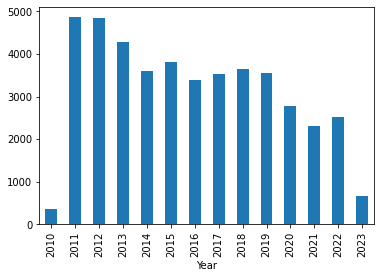

In [65]:
filtered_df.groupby(['Year'])['Location'].count().plot(kind='bar')

In [20]:
# add a new column number of crimes to barnet_df, set the value to 0, and then increment the value by 1 for each crime in filtered_df that belongs to the ward

barnet_df['number of crimes'] = 0

for i in range(len(filtered_df)):
    barnet_df.loc[barnet_df['name'] == filtered_df['Ward'][i], 'number of crimes'] += 1

barnet_df.head()

# filtered_df.to_csv(r'.\\Datasets\\Crime History\\Ward Level Crime.csv', index=False)

,name,boundaries,number of crimes
id,,,
E05013545,Edgware,"[(51.612277994295, -0.28101069219112), (51.611...",1768
E05013628,Barnet Vale,"[(51.634276016337, -0.17977180627771), (51.634...",1231
E05013629,Brunswick Park,"[(51.627511902482, -0.15625171052302), (51.627...",1199
E05013630,Burnt Oak,"[(51.597724278003, -0.25291781885811), (51.597...",1022
E05013631,Childs Hill,"[(51.559882977663, -0.19691984536718), (51.559...",2060


In [21]:
barnet_df

,name,boundaries,number of crimes
id,,,
E05013545,Edgware,"[(51.612277994295, -0.28101069219112), (51.611...",1768
E05013628,Barnet Vale,"[(51.634276016337, -0.17977180627771), (51.634...",1231
E05013629,Brunswick Park,"[(51.627511902482, -0.15625171052302), (51.627...",1199
E05013630,Burnt Oak,"[(51.597724278003, -0.25291781885811), (51.597...",1022
E05013631,Childs Hill,"[(51.559882977663, -0.19691984536718), (51.559...",2060
E05013632,Colindale North,"[(51.597724278003, -0.25291781885811), (51.597...",237
E05013633,Colindale South,"[(51.597724278003, -0.25291781885811), (51.597...",359
E05013634,Cricklewood,"[(51.556035194017, -0.20921111227133), (51.556...",420
E05013635,East Barnet,"[(51.660577323544, -0.17555928061237), (51.660...",616


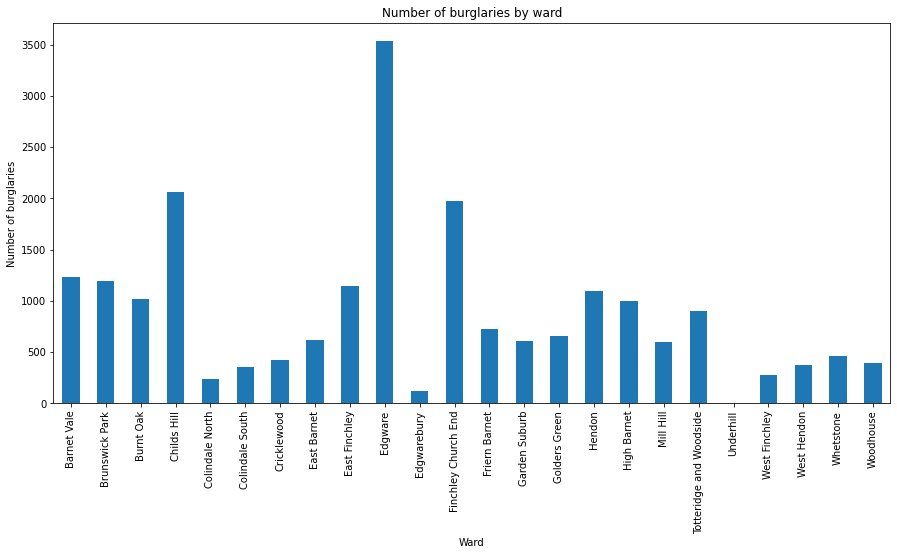

In [22]:
# plot the number of crimes by each ward in a bar chart
fig, ax = plt.subplots(figsize=(15,7))

barnet_df.groupby(['name'])['number of crimes'].sum().plot(ax=ax, kind='bar')

plt.title('Number of burglaries by ward')
plt.xlabel('Ward')
plt.ylabel('Number of burglaries')

plt.show()

In [23]:
df_training = filtered_df.loc[(filtered_df['Year'] != 2022) | (filtered_df['Year'] != 2023)]
df_val = filtered_df.loc[(filtered_df['Year'] == 2022) | (filtered_df['Year'] == 2023)]
training_grouped = df_training.groupby(['Date']).count()
validation_grouped = df_val.groupby(['Date']).count()

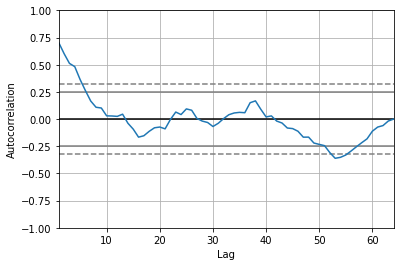

In [24]:
s = training_grouped['Location']

# Creating Autocorrelation plot
x = pd.plotting.autocorrelation_plot(s)
 
# plotting the Curve
x.plot()
 
# Display
plt.show()

<AxesSubplot: xlabel='Date'>

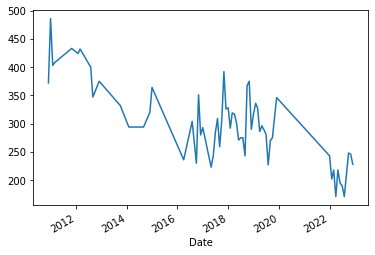

In [25]:
# Growth of burglaries over the years
s.plot()

p-value: 0.0710197119050112


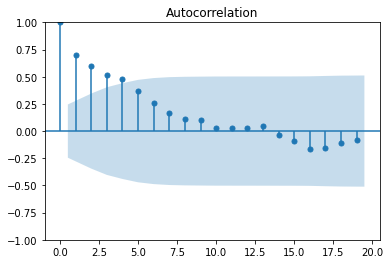

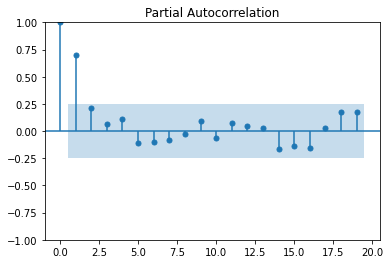

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# ADF test to see stationarity
adf_test = adfuller(training_grouped[['Location']])
# When p <= 0.05, then data is stationary
print(f'p-value: {adf_test[1]}')
# Compute autocorrelation
acf = plot_acf(training_grouped[['Location']])

# Compute partial autocorrelation function
pacf = plot_pacf(training_grouped[['Location']])

# any line inside the blue area shouldn't be considered.

In [27]:
# Since ARIMA model only accepts non-seasonal dataset, we take the difference between
df_train_diff = training_grouped.diff().dropna()
df_train_diff.head()

,Crime ID,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Year,Month,Month name,Ward
Date,,,,,,,,,,,,,,
2011-01-01,0.0,114.0,114.0,114.0,114.0,114.0,114.0,114.0,114.0,0.0,114.0,114.0,114.0,114.0
2011-02-01,0.0,-83.0,-83.0,-83.0,-83.0,-83.0,-83.0,-83.0,-83.0,0.0,-83.0,-83.0,-83.0,-83.0
2011-03-01,0.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,5.0,5.0,5.0,5.0
2011-11-01,0.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,0.0,25.0,25.0,25.0,25.0
2012-02-01,424.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,424.0,-9.0,-9.0,-9.0,-9.0


p-value: 1.4057110130215475e-09


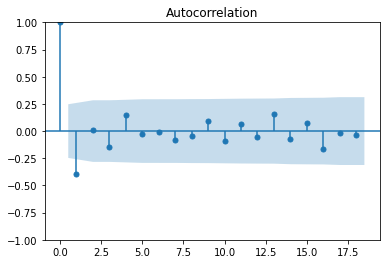

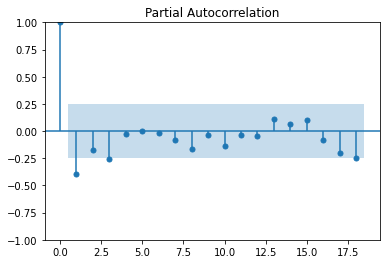

In [28]:
# ADF test to see stationarity
adf_test_new = adfuller(df_train_diff[['Location']])
# When p <= 0.05, then data is stationary
print(f'p-value: {adf_test_new[1]}')
# Compute autocorrelation
acf = plot_acf(df_train_diff[['Location']])

# Compute partial autocorrelation function
pacf = plot_pacf(df_train_diff[['Location']])

In [29]:
from statsmodels.tsa.arima.model import ARIMA
# fit model
model = ARIMA(df_train_diff['Location'], order=(3,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                               SARIMAX Results                                
Dep. Variable:               Location   No. Observations:                   63
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -335.829
Date:                Wed, 21 Jun 2023   AIC                            679.657
Time:                        20:52:35   BIC                            688.166
Sample:                             0   HQIC                           682.998
                                 - 63                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0569      0.145     -7.299      0.000      -1.341      -0.773
ar.L2         -0.7707      0.161     -4.775      0.000      -1.087      -0.454
ar.L3         -0.4532      0.134     -3.374      0.0

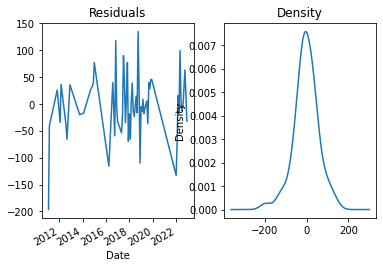

In [30]:
import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

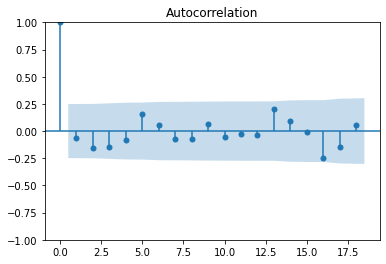

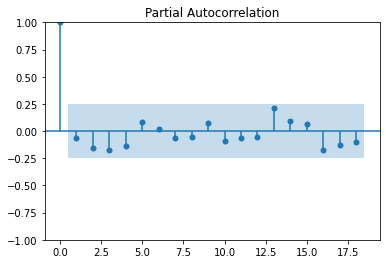

In [31]:
#plot acf and pacf of the residuals
acf_res = plot_acf(residuals)

pacf_res = plot_pacf(residuals)

In [32]:
# assigns the starting and ending prediction dates
pred_start_date=validation_grouped.index[0]
pred_end_date=validation_grouped.index[-1]
print(pred_start_date, pred_end_date)

2022-01-01 00:00:00 2022-12-01 00:00:00


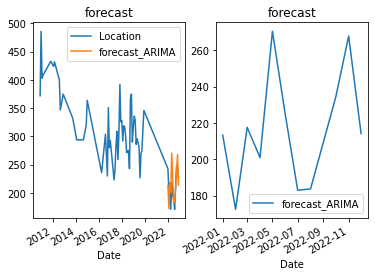

<Figure size 720x720 with 0 Axes>

In [33]:
forecast_test = model_fit.predict(start=pred_start_date, end=pred_end_date)
validation_grouped['forecast_ARIMA'] = validation_grouped['Location'] - forecast_test

fig1, ax1 = plt.subplots(1,2)
training_grouped[['Location']].plot(title='Original', ax=ax1[0])
validation_grouped[['forecast_ARIMA']].plot(title='forecast', ax=ax1[0])
validation_grouped[['forecast_ARIMA']].plot(title='forecast', ax=ax1[1])
plt.figure(figsize=(10,10))
plt.show()

<AxesSubplot: xlabel='Date'>

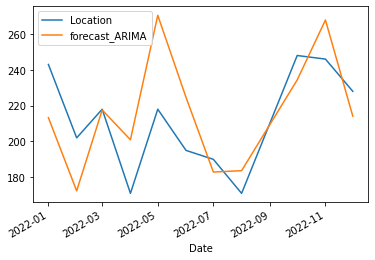

In [34]:
validation_grouped[['Location','forecast_ARIMA']].plot()

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

train, test = training_grouped['Location'], validation_grouped['Location']
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(3,1,0))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MSE: %.3f' % mse)

predicted=218.248863, expected=243.000000
predicted=240.596620, expected=202.000000
predicted=223.657112, expected=218.000000
predicted=217.089355, expected=171.000000
predicted=201.091844, expected=218.000000
predicted=201.517164, expected=195.000000
predicted=206.495693, expected=190.000000
predicted=187.348236, expected=171.000000
predicted=187.893526, expected=248.000000
predicted=213.121172, expected=246.000000
predicted=231.311475, expected=228.000000
Test RMSE: 29.895
Test MAE: 24.333
Test MSE: 893.732


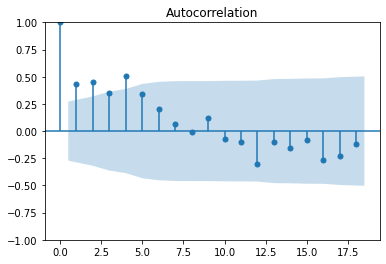

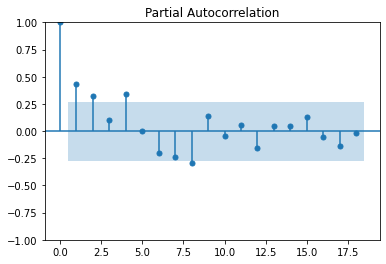

In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

training_grouped['12 Difference']=training_grouped['Location']-training_grouped['Location'].shift(12)

acf12 = plot_acf(training_grouped["12 Difference"].dropna())
pacf12 = plot_pacf(training_grouped["12 Difference"].dropna())

In [37]:
model_SARIMA=SARIMAX(training_grouped['Location'],order=(2,0,4),seasonal_order=(0,1,0,12))
model_SARIMA_fit=model_SARIMA.fit()
pred_Sarima=model_SARIMA_fit.predict(start=pred_start_date,end=pred_end_date)
validation_grouped['forecast_SARIMAX'] = validation_grouped['Location'] - pred_Sarima

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



<AxesSubplot: ylabel='Density'>

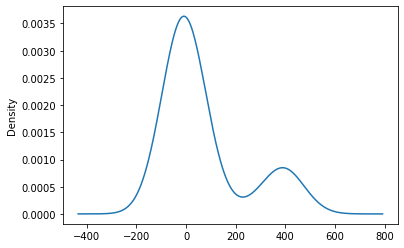

In [38]:
model_SARIMA_fit.resid.plot(kind='kde')

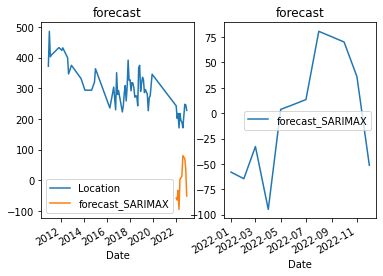

<Figure size 720x720 with 0 Axes>

In [39]:
fig12, ax12 = plt.subplots(1,2)
training_grouped[['Location']].plot(title='Original', ax=ax12[0])
validation_grouped[['forecast_SARIMAX']].plot(title='forecast', ax=ax12[0])
validation_grouped[['forecast_SARIMAX']].plot(title='forecast', ax=ax12[1])
plt.figure(figsize=(10,10))
plt.show()

<AxesSubplot: xlabel='Date'>

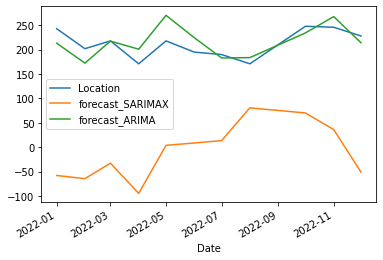

In [40]:
validation_grouped[['Location','forecast_SARIMAX', 'forecast_ARIMA']].plot()

In [41]:
train, test = training_grouped['Location'], validation_grouped['Location']
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
 model = SARIMAX(history, order=(2,0,4),seasonal_order=(0,1,0,12))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MSE: %.3f' % mse)

predicted=366.384925, expected=243.000000
predicted=229.588204, expected=202.000000
predicted=181.924012, expected=218.000000
predicted=183.956700, expected=171.000000
predicted=109.486017, expected=218.000000
predicted=189.691651, expected=195.000000
predicted=188.740439, expected=190.000000
predicted=172.291586, expected=171.000000
predicted=207.615704, expected=248.000000
predicted=256.903274, expected=246.000000
predicted=275.807136, expected=228.000000
Test RMSE: 55.018
Test MAE: 37.770
Test MSE: 3026.938


In [72]:
burglary_data_grouped = filtered_df.groupby(['Year', 'Month num']).count()
burglary_data_grouped.reset_index(inplace=True)
fig_mult = px.line(burglary_data_grouped, x='Month num', y='Location', color='Year',
                   title="Monthly Plot: Burglary Cases Growth")
fig_mult.update_yaxes(title="Number of Cases")
fig_mult.update_traces(mode="markers+lines", hovertemplate=None)
fig_mult.update_layout(hovermode="x unified")

fig_mult.show()

In [43]:
import pmdarima as pm
# Auto ARIMA determines the possible parameters for the model
auto_arima = pm.auto_arima(df_train_diff[['Location']], stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(0, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [44]:
# Summary of Auto ARIMA model
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   63
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -329.276
Date:                Wed, 21 Jun 2023   AIC                            662.552
Time:                        20:52:52   BIC                            666.839
Sample:                             0   HQIC                           664.238
                                 - 63                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5503      0.113     -4.871      0.000      -0.772      -0.329
sigma2      2017.5840    370.854      5.440      0.000    1290.724    2744.444
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.62
Prob(Q):                              0.93   Prob(JB):                         0.27
Heteroskedasticity (H):               0.62   Skew:                             0.49
Prob(H) (two-sided):                  0.28   Kurtosis:                         3.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



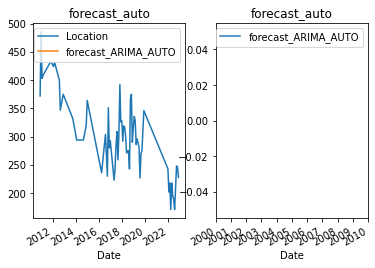

<Figure size 720x720 with 0 Axes>

In [45]:
# Plots the forecasted data against the actual data
forecast_test_auto = auto_arima.predict(start=pred_start_date, end=pred_end_date)
validation_grouped['forecast_ARIMA_AUTO'] = validation_grouped['Location'] - forecast_test_auto

fig2, ax2 = plt.subplots(1,2)
training_grouped[['Location']].plot(title='Original', ax=ax2[0])
validation_grouped[['forecast_ARIMA_AUTO']].plot(title='forecast_auto', ax=ax2[0])
validation_grouped[['forecast_ARIMA_AUTO']].plot(title='forecast_auto', ax=ax2[1])
plt.figure(figsize=(10,10))
plt.show()

<AxesSubplot: xlabel='Date'>

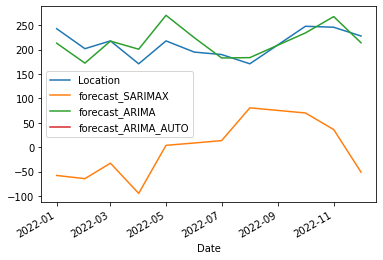

In [46]:
# Compares the performance of ARIMA, SARIMAX, and Auto ARIMA
validation_grouped[['Location','forecast_SARIMAX', 'forecast_ARIMA', 'forecast_ARIMA_AUTO']].plot()

In [47]:
xls = pd.ExcelFile(r'.\\Datasets\\Police Workforce\\open-data-table-police-workforce-270722.ods')

# List all sheets in the file
xls.sheet_names

pwf = pd.read_excel(r'.\\Datasets\\Police Workforce\\open-data-table-police-workforce-270722.ods', sheet_name='Data')
pwf.head()


,As at 31 March...,Geo code,Force Name,Region,Sex,Rank description,Worker type,Total (headcount),Total (FTE)
0,2007,E23000036,Avon & Somerset,South West,Female,Chief Inspector,Police Officer,7,6.60
1,2007,E23000036,Avon & Somerset,South West,Female,Chief Officer,Police Officer,1,1.00
2,2007,E23000036,Avon & Somerset,South West,Female,Chief Superintendent,Police Officer,4,4.00
3,2007,E23000036,Avon & Somerset,South West,Female,Community Support Officer,Police Community Support Officer,170,164.99
4,2007,E23000036,Avon & Somerset,South West,Female,Constable,Police Officer,722,672.76


In [48]:
# Dataset filtering where only Metropolitan police force is taken starting from the year 2010
pwf_data_all_years = pwf.loc[(pwf['Force Name']=='Metropolitan Police') & (pwf['Total (headcount)'] != 0) & (pwf['As at 31 March...'] >= 2010)]
pwf_data_all_years = pwf_data_all_years.rename(columns={'As at 31 March...':'Year'})

# Replaces NaN values wiwth 0's
pwf_data_all_years = pwf_data_all_years.fillna(0)
pwf_data_all_years['Total (FTE)'] = pwf_data_all_years['Total (FTE)'].astype(int)
pwf_data_all_years.head()

,Year,Geo code,Force Name,Region,Sex,Rank description,Worker type,Total (headcount),Total (FTE)
4710,2010,E23000001,Metropolitan Police,London,Female,Chief Inspector,Police Officer,55,54
4711,2010,E23000001,Metropolitan Police,London,Female,Chief Officer,Police Officer,6,6
4712,2010,E23000001,Metropolitan Police,London,Female,Chief Superintendent,Police Officer,7,7
4713,2010,E23000001,Metropolitan Police,London,Female,Community Support Officer,Police Community Support Officer,1658,1613
4714,2010,E23000001,Metropolitan Police,London,Female,Constable,Police Officer,6873,6514


In [49]:
# Retrieves the total police workforce in all years
total = []
for y in pwf_data_all_years['Year'].unique():
    df_temp = pwf_data_all_years[pwf_data_all_years['Year']==y]

    # The item appended is the pair (year, total workforce of that year)
    total.append([y, df_temp['Total (FTE)'].sum()])

# Create the pandas DataFrame
dfwf = pd.DataFrame(total, columns=['Year', 'Police Workforce'])
  
# prints dataframe.
dfwf

,Year,Police Workforce
0,2010,52509
1,2011,50572
2,2012,48179
3,2013,46121
4,2014,45010
5,2015,45564
6,2016,43909
7,2017,41868
8,2018,40321
9,2019,40791


In [50]:
burglary_data_grouped['Police Workforce'] = dfwf['Police Workforce']
burglary_data_grouped.head()

,Year,Month,Crime ID,Date,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Month name,Ward,Police Workforce
0,2010,12,0,372,372,372,372,372,372,372,372,372,0,372,372,52509.0
1,2011,1,0,486,486,486,486,486,486,486,486,486,0,486,486,50572.0
2,2011,2,0,403,403,403,403,403,403,403,403,403,0,403,403,48179.0
3,2011,3,0,408,408,408,408,408,408,408,408,408,0,408,408,46121.0
4,2011,11,0,433,433,433,433,433,433,433,433,433,0,433,433,45010.0


In [51]:
import xlwings as xw

# Retrieves the population growth through the years
# Need to automate some processes
workbook = xw.Book(r'.\\Datasets\\Population\\land-area-population-density-london.xlsx')
ward_sheet = workbook.sheets['Ward']
years = [x for x in range(2010, 2024)]
results = []
for year in years:
    ward_sheet.range('E1').value = year
    ward_sheet.api.Range("A2:K628").AutoFilter(Field:=3, Criteria1:="Barnet")
    results.append(
        {
            'Codes': ward_sheet.range('A21:A41').value,
            'Ward': ward_sheet.range('B21:B41').value,
            'Borough': ward_sheet.range('C21:C41').value,
            'Population': ward_sheet.range('D21:D41').value,
            'Year': [year]*21,
            'Hectares': ward_sheet.range('E21:E41').value,
            'Square Kilometres': ward_sheet.range('F21:F41').value,
            'Population per hectare': ward_sheet.range('G21:G41').value,	
            'Population per square kilometre': ward_sheet.range('H21:H41').value,
            'Census population (2011)': ward_sheet.range('J21:J41').value,	
            'Population per hectare': ward_sheet.range('K21:K41').value,
        }
    )

# Concatenate all the dataframes for the different years into a single dataframe
concat_pd = []
for i in range(len(results)):
    temp_df = pd.DataFrame(results[i])
    concat_pd.append(temp_df)
population_ward_df = pd.concat(concat_pd, ignore_index=True)
population_ward_df.head(-1)

,Codes,Ward,Borough,Population,Year,Hectares,Square Kilometres,Population per hectare,Population per square kilometre,Census population (2011)
0,E05000043,Brunswick Park,Barnet,None,2010,317.4,3.174,51.650914,None,16394.0
1,E05000044,Burnt Oak,Barnet,None,2010,206.4,2.064,88.260659,None,18217.0
2,E05000045,Childs Hill,Barnet,None,2010,308.9,3.089,64.904500,None,20049.0
3,E05000046,Colindale,Barnet,None,2010,264.2,2.642,64.716124,None,17098.0
4,E05000047,Coppetts,Barnet,None,2010,272.0,2.720,63.419118,None,17250.0
...,...,...,...,...,...,...,...,...,...,...
288,E05000058,Oakleigh,Barnet,17043.0,2023,331.7,3.317,47.666566,5138.076575,15811.0
289,E05000059,Totteridge,Barnet,17880.0,2023,876.8,8.768,17.289005,2039.233577,15159.0
290,E05000060,Underhill,Barnet,16595.0,2023,455.2,4.552,34.962654,3645.650264,15915.0
291,E05000061,West Finchley,Barnet,17743.0,2023,216.1,2.161,76.506247,8210.550671,16533.0


In [52]:
population_ward_df.loc[population_ward_df['Ward']=="Edgware"]

,Codes,Ward,Borough,Population,Year,Hectares,Square Kilometres,Population per hectare,Population per square kilometre,Census population (2011)
7,E05000050,Edgware,Barnet,None,2010,556.0,5.56,30.086331,None,16728.0
28,E05000050,Edgware,Barnet,16787.0,2011,556.0,5.56,30.086331,3019.244604,16728.0
49,E05000050,Edgware,Barnet,17299.0,2012,556.0,5.56,30.086331,3111.330935,16728.0
70,E05000050,Edgware,Barnet,17627.0,2013,556.0,5.56,30.086331,3170.323741,16728.0
91,E05000050,Edgware,Barnet,18175.0,2014,556.0,5.56,30.086331,3268.884892,16728.0
112,E05000050,Edgware,Barnet,18633.0,2015,556.0,5.56,30.086331,3351.258993,16728.0
133,E05000050,Edgware,Barnet,19706.0,2016,556.0,5.56,30.086331,3544.244604,16728.0
154,E05000050,Edgware,Barnet,20021.0,2017,556.0,5.56,30.086331,3600.899281,16728.0
175,E05000050,Edgware,Barnet,20359.0,2018,556.0,5.56,30.086331,3661.690647,16728.0
196,E05000050,Edgware,Barnet,20656.0,2019,556.0,5.56,30.086331,3715.107914,16728.0


In [53]:
crime_ward_df = pd.read_csv(r'.\\Datasets\\Crime History\\Ward Level Crime.csv')
crime_ward_df_grouped = crime_ward_df.groupby(['Ward', 'Year', 'Month' ], as_index=False)['Crime type'].count()
crime_ward_df_grouped.head()	

,Ward,Year,Month,Crime type
0,Barnet Vale,2010,12,21
1,Barnet Vale,2011,1,31
2,Barnet Vale,2011,2,29
3,Barnet Vale,2011,3,27
4,Barnet Vale,2011,11,28


In [54]:
# Plot for the burglary cases across the years in each ward
fig_ward = px.line(crime_ward_df.groupby(['Ward', 'Year']).size().reset_index(name='Burglary Rate'), x='Year', y='Burglary Rate', color='Ward',
                   title="Seasonal Plot: Ward Burglary Cases Growth")
fig_ward.update_yaxes(title="Number of Cases")
fig_ward.update_traces(mode="markers+lines", hovertemplate=None)
fig_ward.update_layout(hovermode="x unified")

fig_ward.show()

In [55]:
df2 = pd.merge(crime_ward_df.groupby(['Date', 'Ward', 'Year', 'Reported by', 'Falls within', 'Crime type']).size().reset_index(name='Burglary Rate'), population_ward_df, how='inner', on=['Year', 'Ward'])

df3 = pd.merge(df2, dfwf, how='inner', on='Year')
df3.head()

,Date,Ward,Year,Reported by,Falls within,Crime type,Burglary Rate,Codes,Borough,Population,Hectares,Square Kilometres,Population per hectare,Population per square kilometre,Census population (2011),Police Workforce
0,2010-12-01,Brunswick Park,2010,Metropolitan Police Service,Metropolitan Police Service,Burglary,19,E05000043,Barnet,None,317.4,3.174,51.650914,None,16394.0,52509
1,2010-12-01,Burnt Oak,2010,Metropolitan Police Service,Metropolitan Police Service,Burglary,13,E05000044,Barnet,None,206.4,2.064,88.260659,None,18217.0,52509
2,2010-12-01,Childs Hill,2010,Metropolitan Police Service,Metropolitan Police Service,Burglary,30,E05000045,Barnet,None,308.9,3.089,64.904500,None,20049.0,52509
3,2010-12-01,East Barnet,2010,Metropolitan Police Service,Metropolitan Police Service,Burglary,12,E05000048,Barnet,None,375.2,3.752,43.009062,None,16137.0,52509
4,2010-12-01,East Finchley,2010,Metropolitan Police Service,Metropolitan Police Service,Burglary,32,E05000049,Barnet,None,252.4,2.524,63.347861,None,15989.0,52509


In [56]:
# Obtains the income data of each ward in Barnet from 2010 to 2012
income_ward_df = pd.read_csv(r'.\\Datasets\\Population\\modelled-household-income-estimates-wards.csv', encoding='latin1')
income_ward_df = income_ward_df.loc[(income_ward_df['Borough']=='Barnet')]
tomelt = [income_ward_df.columns[i] for i in range(0, 4)]
income_ward_df = pd.melt(income_ward_df, id_vars=tomelt, 
        var_name="Date", 
        value_name="Mean Income (£)")
temp_df = income_ward_df[income_ward_df['Date'].str.contains("Median")]
temp_df = temp_df.rename(columns={'Mean Income (£)':'Median Income (£)'})
income_ward_df = income_ward_df[income_ward_df['Date'].str.contains("Mean")]
income_ward_df = pd.concat([income_ward_df.reset_index(drop=True), temp_df[['Median Income (£)']].reset_index(drop=True)], axis=1)
income_ward_df[income_ward_df.columns[5:]] = income_ward_df[income_ward_df.columns[5:]].replace('[\£,]', '', regex=True).astype(float)
income_ward_df['Year'] = income_ward_df.Date.str[5:9]
income_ward_df = income_ward_df.drop(['Date'], axis=1)
income_ward_df['Year']  = income_ward_df['Year'].astype('Int64')
income_ward_df = income_ward_df.rename({'Code' : 'Codes', 'Ward name' : 'Ward'}, axis=1)
income_ward_df

,Codes,Ward,LAD code,Borough,Mean Income (£),Median Income (£),Year
0,E05000043,Brunswick Park,E09000003,Barnet,37840.0,28580.0,2001
1,E05000044,Burnt Oak,E09000003,Barnet,26640.0,20460.0,2001
2,E05000045,Childs Hill,E09000003,Barnet,38500.0,29020.0,2001
3,E05000046,Colindale,E09000003,Barnet,27820.0,21380.0,2001
4,E05000047,Coppetts,E09000003,Barnet,36930.0,27960.0,2001
...,...,...,...,...,...,...,...
247,E05000059,Totteridge,E09000003,Barnet,63320.0,46150.0,2012
248,E05000060,Underhill,E09000003,Barnet,49390.0,37040.0,2012
249,E05000061,West Finchley,E09000003,Barnet,56850.0,42050.0,2012
250,E05000062,West Hendon,E09000003,Barnet,46620.0,35090.0,2012


In [57]:
df4 = df3.merge(income_ward_df[income_ward_df['Year']>=2011], how='left', left_on=['Year', 'Ward', 'Codes', 'Borough'], right_on=['Year', 'Ward', 'Codes', 'Borough'])
wardinter = {}
wardinter1 = {}
for ward in df4['Ward'].unique():
    wardinter[ward] = df4[df4['Ward']==ward]['Mean Income (£)'].interpolate('spline', order=1)
    wardinter1[ward] = df4[df4['Ward']==ward]['Median Income (£)'].interpolate('spline', order=1)
    df4.loc[df4['Ward']==ward, 'Mean Income (£)'] = wardinter[ward]
    df4.loc[df4['Ward']==ward, 'Median Income (£)'] = wardinter1[ward]
df4.head(-1)


,Date,Ward,Year,Reported by,Falls within,Crime type,Burglary Rate,Codes,Borough,Population,Hectares,Square Kilometres,Population per hectare,Population per square kilometre,Census population (2011),Police Workforce,LAD code,Mean Income (£),Median Income (£)
0,2010-12-01,Brunswick Park,2010,Metropolitan Police Service,Metropolitan Police Service,Burglary,19,E05000043,Barnet,None,317.4,3.174,51.650914,None,16394.0,52509,NaN,NaN,NaN
1,2010-12-01,Burnt Oak,2010,Metropolitan Police Service,Metropolitan Police Service,Burglary,13,E05000044,Barnet,None,206.4,2.064,88.260659,None,18217.0,52509,NaN,NaN,NaN
2,2010-12-01,Childs Hill,2010,Metropolitan Police Service,Metropolitan Police Service,Burglary,30,E05000045,Barnet,None,308.9,3.089,64.904500,None,20049.0,52509,NaN,NaN,NaN
3,2010-12-01,East Barnet,2010,Metropolitan Police Service,Metropolitan Police Service,Burglary,12,E05000048,Barnet,None,375.2,3.752,43.009062,None,16137.0,52509,NaN,NaN,NaN
4,2010-12-01,East Finchley,2010,Metropolitan Police Service,Metropolitan Police Service,Burglary,32,E05000049,Barnet,None,252.4,2.524,63.347861,None,15989.0,52509,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
949,2022-06-01,Woodhouse,2022,Metropolitan Police Service,Metropolitan Police Service,Burglary,6,E05000063,Barnet,18844.0,261.2,2.612,67.285605,7214.3951,17575.0,45138,NaN,51469.654200,38670.252100
950,2022-07-01,Woodhouse,2022,Metropolitan Police Service,Metropolitan Police Service,Burglary,3,E05000063,Barnet,18844.0,261.2,2.612,67.285605,7214.3951,17575.0,45138,NaN,51470.115143,38670.813544
951,2022-08-01,Woodhouse,2022,Metropolitan Police Service,Metropolitan Police Service,Burglary,1,E05000063,Barnet,18844.0,261.2,2.612,67.285605,7214.3951,17575.0,45138,NaN,51470.576086,38671.374988
952,2022-10-01,Woodhouse,2022,Metropolitan Police Service,Metropolitan Police Service,Burglary,4,E05000063,Barnet,18844.0,261.2,2.612,67.285605,7214.3951,17575.0,45138,NaN,51471.037028,38671.936432


In [58]:
# Plot of income growth in each ward in Barnet
fig_income = px.line(df4, x='Year', y='Mean Income (£)', color='Ward',
                   title="Seasonal Plot: Income Growth")
fig_income.update_yaxes(title="Mean Income (£)")
fig_income.update_traces(mode="markers+lines", hovertemplate=None)
fig_income.update_layout(hovermode="x unified")

fig_income.show()

In [59]:
import plotly.graph_objects as go

Real_df = df4.loc[(df4['Year'] <= 2012)]
fig_pcp = go.Figure(data=
    go.Parcoords(
        line = dict(colorscale = 'Electric',
                   showscale = True),
        dimensions = list([
            dict(
                 label = "Year", values = Real_df['Year']),
            dict(range = [0,40000],
                 label = 'Population per Ward', values = Real_df['Population']),
            dict(range = [0,80000],
                 visible = True,
                 label = 'Mean Income', values = Real_df['Mean Income (£)']),
            dict(range = [0,80000],
                 label = 'Police Workforce', values = Real_df['Police Workforce']),
            dict(range = [0,200],
                 ticktext = ['0','50','100','150','200'],
                 label = 'Burglary Rate per Day', values = Real_df['Burglary Rate']),
            dict(range = [0,80000],
                 label = 'Median Income', values = Real_df['Median Income (£)'])])
    )
)
fig_pcp.show()

In [76]:
filtered_df = pd.read_csv(r'.\\Datasets\\Population\\filtered_df.csv')
filtered_df = filtered_df.rename(columns={'Ward new' : 'Ward', 'Month' : 'Date'})
filtered_df_new = filtered_df.groupby(['Date', 'Ward', 'Year', 'Falls within', 'Month num']).size().reset_index(name='Burglary Rate')
filtered_df_new = filtered_df_new.merge(income_ward_df, how='left', left_on=['Year', 'Ward'], right_on=['Year', 'Ward'])
filtered_df_new = filtered_df_new.fillna(value=np.nan)

filtered_df_new[filtered_df_new['Year']==2013]

,Date,Ward,Year,Falls within,Month num,Burglary Rate,Codes,LAD code,Borough,Mean Income (£),Median Income (£)
586,2013-01,Brunswick Park,2013,Metropolitan Police Service,1,35,NaN,NaN,NaN,NaN,NaN
587,2013-01,Burnt Oak,2013,Metropolitan Police Service,1,27,NaN,NaN,NaN,NaN,NaN
588,2013-01,Childs Hill,2013,Metropolitan Police Service,1,18,NaN,NaN,NaN,NaN,NaN
589,2013-01,Colindale North,2013,Metropolitan Police Service,1,29,NaN,NaN,NaN,NaN,NaN
590,2013-01,Colindale South,2013,Metropolitan Police Service,1,9,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
863,2013-12,Underhill,2013,Metropolitan Police Service,12,15,NaN,NaN,NaN,NaN,NaN
864,2013-12,West Finchley,2013,Metropolitan Police Service,12,10,NaN,NaN,NaN,NaN,NaN
865,2013-12,West Hendon,2013,Metropolitan Police Service,12,19,NaN,NaN,NaN,NaN,NaN
866,2013-12,Whetstone,2013,Metropolitan Police Service,12,25,NaN,NaN,NaN,NaN,NaN


In [61]:
Real_df_1 = filtered_df_new.loc[(filtered_df_new['Year'] <= 2012)]
Real_df_1 = Real_df_1.dropna()
fig_pcp_1 = go.Figure(data=
    go.Parcoords(
        line = dict(colorscale = 'Electric',
                   showscale = True),
        dimensions = list([
            dict(
                 label = "Year", values = Real_df_1['Year']),
            dict(range = [0,80000],
                 visible = True,
                 label = 'Mean Income', values = Real_df_1['Mean Income (£)']),
            dict(range = [0,200],
                 ticktext = ['0','50','100','150','200'],
                 label = 'Burglary Rate per Day', values = Real_df_1['Burglary Rate'])])
    )
)
fig_pcp_1.show()